In [29]:
import pandas as pd; pd.set_option('precision',4)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np; np.set_printoptions(precision=4,suppress = True)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.gridspec as gridspec
from datetime import datetime

fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title


# StandardScale all x-variables - improves performance and robustness of fitted models
from sklearn.preprocessing import StandardScaler

# All subsets need their own scaler in order to call the inverse_transform method
scaler_train = StandardScaler()
scaler_test = StandardScaler()
scaler_all = StandardScaler()


def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.4f}%")
    else:
        print(text, f"{value:.4f}")

In [30]:
import os 
cwd = os.getcwd()
print(os.getcwd())
os.chdir('/home/math/PycharmProjects/hmm-master')

/home/math/PycharmProjects/hmm-master


In [31]:
df = pd.read_excel('data/adjusted_close_price_series_load.xlsx', header = 2, index_col = 'Time / Name')
df_MSCI = df[['MSCI World']]
df_MSCI['Index prices'] = df['MSCI World'] / df.iloc[0, 1] * 100
df_MSCI.head()

MSCI World  Index prices
Time / Name                          
1980-01-01       7.0217      100.0000
1980-01-02       6.9258       98.6337
1980-01-03       6.9075       98.3727
1980-01-04       6.9630       99.1631
1980-01-07       6.9889       99.5330

In [32]:
df_MSCI['Returns'] = df_MSCI['Index prices'].pct_change()
df_MSCI['Log returns'] = np.log(df_MSCI['Index prices']) - np.log(df_MSCI['Index prices'].shift(1))
df_MSCI

MSCI World  Index prices  Returns  Log returns
Time / Name                                                
1980-01-01       7.0217      100.0000      NaN          NaN
1980-01-02       6.9258       98.6337  -0.0137      -0.0138
1980-01-03       6.9075       98.3727  -0.0026      -0.0027
1980-01-04       6.9630       99.1631   0.0080       0.0080
1980-01-07       6.9889       99.5330   0.0037       0.0037
...                 ...           ...      ...          ...
2021-01-19     167.7060     2388.3908   0.0033       0.0033
2021-01-20     169.6573     2416.1799   0.0116       0.0116
2021-01-21     169.3605     2411.9531  -0.0017      -0.0018
2021-01-22     168.4895     2399.5488  -0.0051      -0.0052
2021-01-25     168.8636     2404.8768   0.0022       0.0022

[10715 rows x 4 columns]

### Train and Test period

In [33]:
# Used for plotting
start_train = '1980-01-01'
end_train = '2014-01-01'

start_test = '2014-01-02'
end_test = '2021-01-25'

# Get train and test as datetimes - used for plotting
start_train_dt = datetime.strptime(start_train, '%Y-%m-%d')
end_train_dt = datetime.strptime(end_train, '%Y-%m-%d')
start_test_dt = datetime.strptime(start_test, '%Y-%m-%d')
end_test_dt = datetime.strptime(end_test, '%Y-%m-%d')

df = df.loc[start_train:end_test]

In [34]:
#Get train & test sets - keep as Dataframe as oppossed to pandas series.
#x_train = pd.DataFrame(df_MSCI.loc[start_train:end_train, 'Log returns'])
#x_test = pd.DataFrame(df_MSCI.loc[start_test:end_test, 'Log returns'])
#x_all = pd.DataFrame(df_MSCI.loc[start_train:end_test, 'Log returns'])

In [35]:
##Scale train & test sets
#x_train_scaled = pd.DataFrame(scaler_train.fit_transform(x_train),
 #            columns = ["Log returns"],
  #           index=x_train.index)
#x_test_scaled = pd.DataFrame(scaler_test.fit_transform(x_test), columns =['Log returns'], index = x_test.index)

#x_all_scaled = pd.DataFrame(scaler_all.fit_transform(x_all), columns = ['Log returns'], index = x_all.index)

In [36]:
#Set variable for index prices and set index 100 to first obs - only used for plotting
prices = df.loc[:,"MSCI World"] / df.iloc[0]["MSCI World"] * 100
df_MSCI['Index prices'] = df.loc[:,"MSCI World"] / df.iloc[0]["MSCI World"] * 100

### Data Exploration

#### Overview of time series

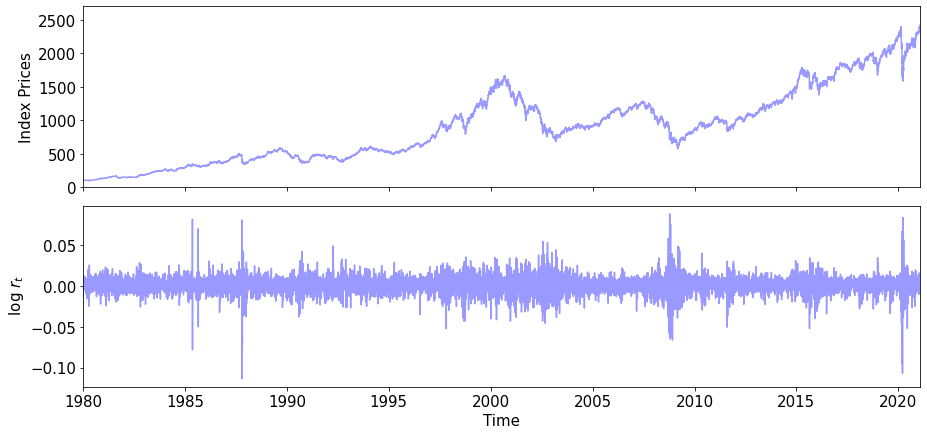

In [38]:
def plot_test_area(ax):
    #Set grey background for in-sample data
    ax.axvspan(start_train_dt, end_train_dt, alpha=0.5, color='white')
    ax.axvspan(start_test_dt, end_test_dt, alpha=0.5, color='grey', label = "Out of sample")

    
#### Plot Index and Log Returns

# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7), sharex=True)
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
labels = ["Index Prices"," log $r_t$"]
variables = [df_MSCI['Index prices'], df_MSCI['Log returns']]
    
for (ax, labels, var) in zip([ax1, ax2], labels, variables):
    ax.plot(df_MSCI.index.values, var, color="b", alpha=0.4)
    ax.set_ylabel(labels)
    ax2.set_xlabel("Time")
    ax.set_xlim(start_train_dt, end_test_dt)
    ax1.set_ylim(0,2700)
    
    
#ax2.set_ylim(bottom=-0.15)
plt.savefig("Index and return")

    
#fig, ax = plt.subplots(figsize=(15,5))

#plt.plot(prices)
#plt.ylabel('Index Prices')
#plt.xlim(start_train_dt, end_test_dt)
#plt.grid()
#plt.tight_layout()
#plt.savefig("MSCI World")

#### Drawdown Calculation

In [79]:
Previous_peaks = df_MSCI['Index prices'].cummax()
df_MSCI['drawdown'] = (df_MSCI['Index prices']-Previous_peaks)/Previous_peaks
df_MSCI.head()

MSCI World  Index prices  Returns  Log returns  Wealth Index  \
Time / Name                                                                 
1980-01-01       7.0217      100.0000      NaN          NaN           NaN   
1980-01-02       6.9258       98.6337  -0.0137      -0.0138      986.3374   
1980-01-03       6.9075       98.3727  -0.0026      -0.0027      983.7271   
1980-01-04       6.9630       99.1631   0.0080       0.0080      991.6311   
1980-01-07       6.9889       99.5330   0.0037       0.0037      995.3297   

             drawdown  
Time / Name            
1980-01-01     0.0000  
1980-01-02    -0.0137  
1980-01-03    -0.0163  
1980-01-04    -0.0084  
1980-01-07    -0.0047

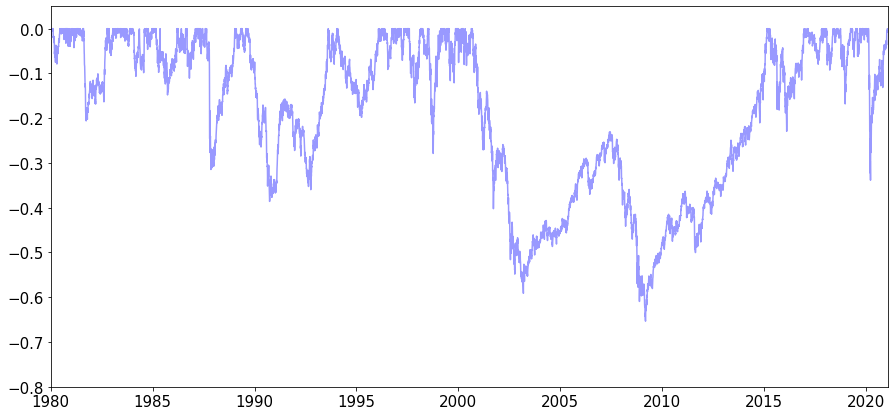

In [97]:
fig, ax3 = plt.subplots(figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
ax3.plot(df_MSCI.index.values,df_MSCI['drawdown'], color="b", alpha=0.4)
ax3.set_ylim(-0.8,0.05)
ax3.set_xlim(start_train_dt, end_test_dt)
plt.show()

In [39]:
df_MSCI

MSCI World  Index prices  Returns  Log returns
Time / Name                                                
1980-01-01       7.0217      100.0000      NaN          NaN
1980-01-02       6.9258       98.6337  -0.0137      -0.0138
1980-01-03       6.9075       98.3727  -0.0026      -0.0027
1980-01-04       6.9630       99.1631   0.0080       0.0080
1980-01-07       6.9889       99.5330   0.0037       0.0037
...                 ...           ...      ...          ...
2021-01-19     167.7060     2388.3908   0.0033       0.0033
2021-01-20     169.6573     2416.1799   0.0116       0.0116
2021-01-21     169.3605     2411.9531  -0.0017      -0.0018
2021-01-22     168.4895     2399.5488  -0.0051      -0.0052
2021-01-25     168.8636     2404.8768   0.0022       0.0022

[10715 rows x 4 columns]

In [48]:
# Summary statistics log returns

display(pd.DataFrame(df_MSCI['Log returns'].describe(include='all')).T.round(4))

printf("Skewness = ", stats.skew(df_MSCI['Log returns'].dropna().round(4))[0])
printf("Excess Kurtosis = ", stats.kurtosis(df_MSCI['Log returns'].dropna())[0])

count    mean   std     min     25%     50%     75%     max
Log returns  10714.0  0.0003  0.01 -0.1134 -0.0045  0.0006  0.0055  0.0876

TypeError: 'float' object is not subscriptable

In [44]:
np.max(df_MSCI['Log returns'].loc[start_train_dt:end_train_dt]) #Test function for the statistics above, out of sample

0.08760270641696177

### ACF and ACF^2 - Absence of Linear Autocorrelation and Volatility clustering


In [45]:
#### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_MSCI['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(np.abs(df_MSCI['Log returns'].dropna()), nlags=n_lags)[1:]

/home/math/PycharmProjects/hmm-master/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [46]:
acf_abs

array([0.2525, 0.2668, 0.2452, 0.2315, 0.2426, 0.2218, 0.2261, 0.188 ,
       0.1953, 0.2017, 0.1876, 0.1715, 0.1774, 0.1643, 0.1734, 0.1544,
       0.1621, 0.1526, 0.1238, 0.1464, 0.1292, 0.1327, 0.1264, 0.1256,
       0.1243, 0.1171, 0.1367, 0.1107, 0.116 , 0.1363, 0.0968, 0.1215,
       0.1117, 0.1103, 0.1131, 0.0963, 0.1079, 0.1053, 0.1146, 0.0905,
       0.0961, 0.0974, 0.0911, 0.0927, 0.0875, 0.0849, 0.0858, 0.0924,
       0.0873, 0.0978, 0.0927, 0.0847, 0.0714, 0.0751, 0.0692, 0.0694,
       0.0894, 0.0698, 0.0745, 0.0755, 0.0795, 0.0672, 0.0784, 0.0679,
       0.0718, 0.063 , 0.0662, 0.0629, 0.0599, 0.0549, 0.0561, 0.0635,
       0.0703, 0.071 , 0.0561, 0.0649, 0.0581, 0.0554, 0.045 , 0.0651,
       0.055 , 0.0524, 0.0399, 0.0438, 0.0394, 0.0467, 0.0494, 0.0518,
       0.0419, 0.0473, 0.0325, 0.0451, 0.0474, 0.0349, 0.0606, 0.0606,
       0.0427, 0.0505, 0.0485, 0.0609])

In [47]:
#### Confidence interval for ACF
acf_conf = [1.96  / np.sqrt(len(df_MSCI)), -1.96 / np.sqrt(len(df_MSCI))]

#### Confidence interval for ACF^2
acf_abs_conf = [1.96 / np.sqrt(len(np.abs(df_MSCI['Log returns']))), - 1.96 / np.sqrt(len(np.abs(df_MSCI['Log returns'])))]

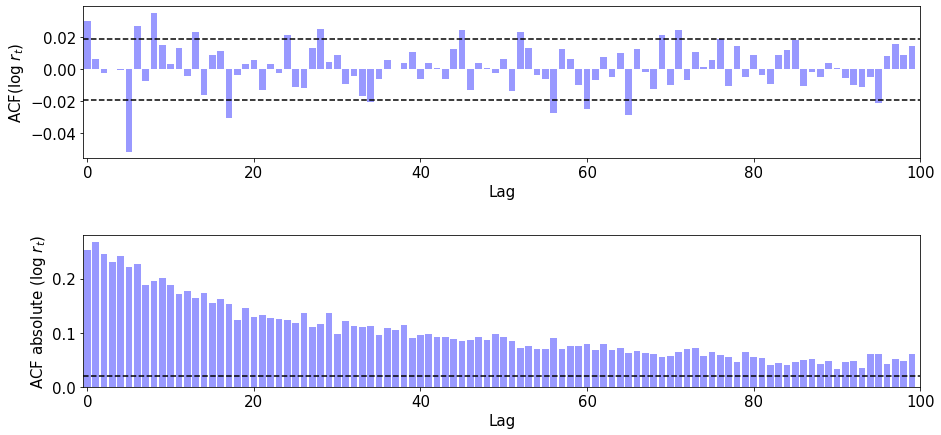

In [393]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF absolute (log $r_t$)"]
variables = [acf, acf_abs]
confidence = [acf_conf, acf_squared_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="b", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig("ACF")
